## 1. Data Exploration and Visualization

- audio 데이터 분석을 위해 아래 두 개 모듈 필요
 * IPython.disaply.Audio => 듣기
 * Librosa => 보기(파형)
 
**사람은 파형이 비슷한 소리도 구분 할 수 있지만,   
과연 딥러닝을 통해 기계를 학습시켰을 때 비슷하게 구분할 수 있을지가 관건!**

In [13]:
import IPython.display as ipd

ipd.Audio('./UrbanSound8K/audio/fold1/180937-7-2-1.wav') # 드릴소리

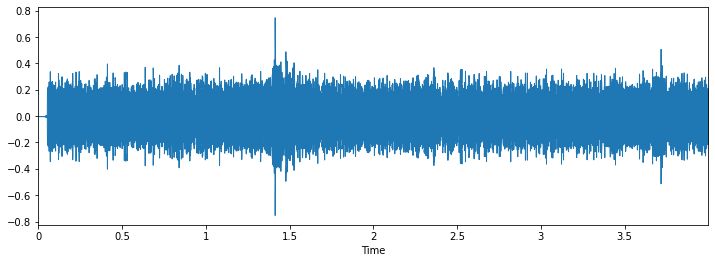

In [34]:
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt

filename = './UrbanSound8K/audio/fold5/100852-0-0-0.wav' # 에어컨소리
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)

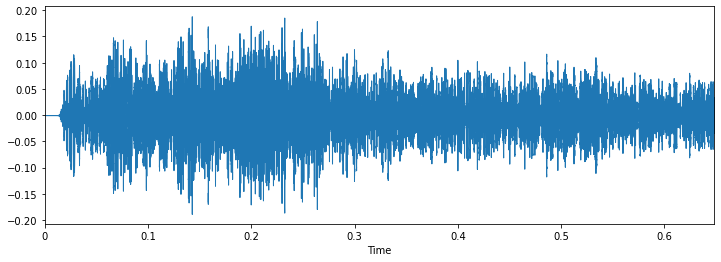

In [36]:
filename = './UrbanSound8K/audio/fold10/100648-1-0-0.wav' # 자동차 경적소리
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)

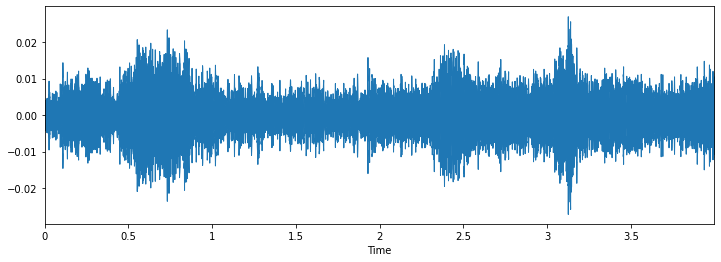

In [38]:
filename = './UrbanSound8K/audio/fold5/100263-2-0-117.wav' # 아이들 뛰노는 소리
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)

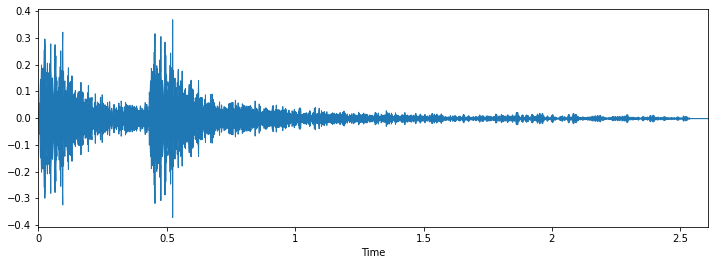

In [39]:
filename = './UrbanSound8K/audio/fold1/102305-6-0-0.wav' # 총 쏘는 소리
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)

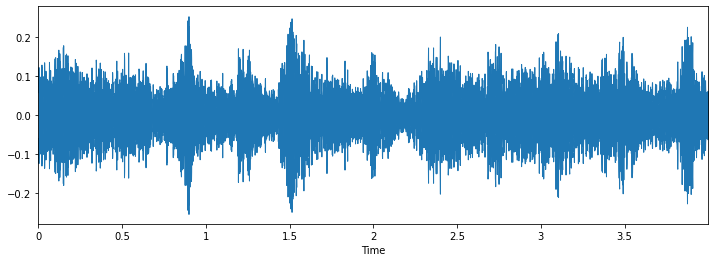

In [40]:
filename = './UrbanSound8K/audio/fold7/101848-9-0-0.wav' # 거리의 음악 소리
plt.figure(figsize=(12,4))
data,sample_rate = librosa.load(filename)
_ = librosa.display.waveplot(data,sr=sample_rate)
ipd.Audio(filename)

In [52]:
# pandas를 통해 urban sound의 metadata .csv 파일을 로드
import pandas as pd
metadata = pd.read_csv('./UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

         class_name  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

In [53]:
# class 구분
# 만약 오류 날 경우, csv 파일을 열어서 class_name 열 이름이 올바르게 지정되었는지 확인
print(metadata.class_name.value_counts())

children_playing    1000
street_music        1000
dog_bark            1000
drilling            1000
jackhammer          1000
engine_idling       1000
air_conditioner     1000
siren                929
car_horn             429
gun_shot             374
Name: class_name, dtype: int64


In [88]:
import struct

class WavFileHelper():
    
    def read_file_properties(self, filename):

        wave_file = open(filename,"rb")
        
        riff = wave_file.read(12)
        fmt = wave_file.read(36)
        
        num_channels_string = fmt[10:12]
        num_channels = struct.unpack('<H', num_channels_string)[0]

        sample_rate_string = fmt[12:16]
        sample_rate = struct.unpack("<I",sample_rate_string)[0]
        
        bit_depth_string = fmt[22:24]
        bit_depth = struct.unpack("<H",bit_depth_string)[0]

        return (num_channels, sample_rate, bit_depth)

In [90]:
# Observation
# 위의 class 별 구분된 결과를 보면 7개의 class는 1000개의 데이터를 모두 동일하게 가지고 있지만,
# 3개의 class(사이렌, 차경적, 총소리)는 모두 1000개가 아닌 데이터를 가지고 있음

# 샘플파일의 속성 확인
# from helpers.wavfilehelper import WavFileHelper # class 상속(호출)
wavfilehelper = WavFileHelper()

audiodata = []
for index, row in metadata.iterrows():
    
    file_name = os.path.join(os.path.abspath('./UrbanSound8K/audio/'),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    data = wavfilehelper.read_file_properties(file_name)
    audiodata.append(data)

# Convert into a Panda dataframe
audiodf = pd.DataFrame(audiodata, columns=['num_channels','sample_rate','bit_depth'])

In [97]:
print(file_name)
print(data)
print(audiodf)

/home/tensorflow/sound_classfication/UrbanSound8K/audio/fold7/99812-1-6-0.wav
(2, 44100, 16)
      num_channels  sample_rate  bit_depth
0                2        44100         16
1                2        44100         16
2                2        44100         16
3                2        44100         16
4                2        44100         16
...            ...          ...        ...
8727             2        44100         16
8728             2        44100         16
8729             2        44100         16
8730             2        44100         16
8731             2        44100         16

[8732 rows x 3 columns]


In [102]:
# Audio channel(Mono / Stereo)
# 가장 쉽게 두 채널을 균일화하는 방법은 평균을 내서 하나로 합치는 것
print(audiodf.num_channels.value_counts(normalize=True))

2    0.915369
1    0.084631
Name: num_channels, dtype: float64


In [98]:
# Sample rate(초당 샘플링 횟수로 주파주 정보를 의미)
# 음원을 세로로 잘게 쪼개는 것
# urban sound에는 96k에서 8k까지 다양한 범위의 sample rate가 존재
# 이를 주파수 변환(up/down conversion)을 통해 파형을 제외하고 비교 가능하도록 만들어줘야 함.
print(audiodf.sample_rate.value_counts(normalize=True))

44100     0.614979
48000     0.286532
96000     0.069858
24000     0.009391
16000     0.005153
22050     0.005039
11025     0.004466
192000    0.001947
8000      0.001374
11024     0.000802
32000     0.000458
Name: sample_rate, dtype: float64


In [99]:
# Bit depth(오디오의 음량 총량을 담는 컨테이너)
# 음원을 가로로 잘게 쪼개는 것(소리가 커질 때 좀 더 부드럽게 커질 수 있음(우.우.웅! -> 우우우우우웅!))
# 최대 및 최소 진폭값(amplitude)을 통해 정규화
print(audiodf.bit_depth.value_counts(normalize=True))

16    0.659414
24    0.315277
32    0.019354
8     0.004924
4     0.001031
Name: bit_depth, dtype: float64


In [103]:
# 고려해야 할 다른 오디오의 속성
# 피크볼륨, RMS 볼륨처럼 크게 변하는 경우 볼륨 레벨(진폭의 값)의 정규화 고려!